# Proyecto 1.1 BI 

Integrantes:
-Maria Fernanda De La Hoz
-Silvana Sandoval 
-Gabriela Soler 

## Preprocesamiento y análisis de datos

### Instalación de spaCy y Modelos de lenguaje

In [1]:
!pip install spacy
!python -m spacy download es_core_news_md


     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/42.3 MB 3.2 MB/s eta 0:00:14
     ---------------------------------------- 0.5/42.3 MB 6.0 MB/s eta 0:00:07
     - -------------------------------------- 1.4/42.3 MB 11.0 MB/s eta 0:00:04
     --- ------------------------------------ 3.5/42.3 MB 18.7 MB/s eta 0:00:03
     ---- ----------------------------------- 5.2/42.3 MB 20.6 MB/s eta 0:00:02
     ------ --------------------------------- 7.1/42.3 MB 21.6 MB/s eta 0:00:02
     ------- -------------------------------- 8.0/42.3 MB 20.5 MB/s eta 0:00:02
     -------- ------------------------------- 9.2/42.3 MB 20.4 MB/s eta 0:00:02
     --------- ----------------------------- 10.5/42.3 MB 23.4 MB/s eta 0:00:02
     ----------- --------------------------- 12.5/42.3 MB 23.4 MB/s eta 0:00:02
     ------------ -------------------------- 13.7/42.3 MB 22.6 MB/s eta 0:00:02
     -------------- ------------------------ 15.2/

### Importación de las librerias pertinentes

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB


### Carga del modelo de lenguaje

In [3]:
import spacy
nlp = spacy.load("es_core_news_md") #En este caso cargamos el modelo de lenguaje español

### Lectura de datos 

In [4]:
import pandas as pd

data = pd.read_excel("ODScat_345.xlsx")

## Entendimiento de los datos

In [5]:
print(data.sample(5))
print("Total de registros: ", data.shape[0])

                                         Textos_espanol  sdg
2226  Los determinantes de la participación femenina...    5
2507  Por lo tanto, son fundamentales para crear un ...    5
4009  En la última década, las brechas salariales de...    5
701   El Parlamento decidió elaborar un plan de acci...    3
3836  Este documento se centra en las reglas del sis...    5
Total de registros:  4049


Se tienen 4049 opiniones de ciudadanos y hay 2 variables: la primera corresponde a la variable Textos_espanol, que es una cadena de caracteres y es la opinión de los ciudadanos. La segunda variable es sdg, que es la variable objetivo, es decir, el ODS correspondiente.

### Unicidad

In [6]:
print("Duplicados: ", data.duplicated().sum())

Duplicados:  0


### Completitud

In [7]:
print(data.isnull().sum())

Textos_espanol    0
sdg               0
dtype: int64


### Validez

In [8]:
data.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [9]:
data.dtypes

Textos_espanol    object
sdg                int64
dtype: object

## Preprocesamiento del texto

In [10]:
# Aplicar spaCy a la columna de opiniones en español
dataCopy = data.copy()
dataCopy['procesado'] = dataCopy['Textos_espanol'].apply(lambda x: nlp(x))
dataCopy[['Textos_espanol', 'procesado']].head()

,Textos_espanol,procesado
0,"Por ejemplo, el nÃºmero de consultas externas ...","(Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...","(En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...","(Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...","(Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","(El, consumo, anual, de, alcohol, se, estima, ..."


### Tokenización

In [11]:
dataCopy['tokens'] = dataCopy['procesado'].apply(lambda doc: [token.text for token in doc])
dataCopy[['Textos_espanol', 'tokens']].head()

,Textos_espanol,tokens
0,"Por ejemplo, el nÃºmero de consultas externas ...","[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...","[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...","[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...","[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[El, consumo, anual, de, alcohol, se, estima, ..."


### Lematización-Obtener la forma base de las palabras

In [12]:
dataCopy['lemmas'] = dataCopy['procesado'].apply(lambda doc: [token.lemma_ for token in doc])
dataCopy[['Textos_espanol', 'lemmas']].head()

,Textos_espanol,lemmas
0,"Por ejemplo, el nÃºmero de consultas externas ...","[por, ejemplo, ,, el, nãºmero, de, consulta, e..."
1,"En 2007, el gobierno central financió directam...","[en, 2007, ,, el, gobierno, central, financiar..."
2,"Claramente, hay muchos otros factores en juego...","[claramente, ,, haber, mucho, otro, factor, en..."
3,"Por ejemplo, el estado australiano de Victoria...","[por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[el, consumo, anual, de, alcohol, él, estimar,..."


### Eliminación de stopWords

In [13]:
dataCopy['lemmas_sin_stopwords'] = dataCopy['procesado'].apply(lambda doc: [token.lemma_ for token in doc if not token.is_stop])
dataCopy[['Textos_espanol', 'lemmas_sin_stopwords']].head()

,Textos_espanol,lemmas_sin_stopwords
0,"Por ejemplo, el nÃºmero de consultas externas ...","[ejemplo, ,, nãºmero, consulta, externo, espec..."
1,"En 2007, el gobierno central financió directam...","[2007, ,, gobierno, central, financiar, direct..."
2,"Claramente, hay muchos otros factores en juego...","[claramente, ,, factor, juego, ,, particular, ..."
3,"Por ejemplo, el estado australiano de Victoria...","[ejemplo, ,, australiano, Victoria, crear, age..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[consumo, anual, alcohol, estimar, 15.7, litro..."


### Filtrado de caracteres especiales

In [14]:
dataCopy['lemmas_limpios'] = dataCopy['lemmas_sin_stopwords'].apply(lambda lemmas: [lemma for lemma in lemmas if lemma.isalpha()])
dataCopy[['Textos_espanol', 'lemmas_limpios']].head()

,Textos_espanol,lemmas_limpios
0,"Por ejemplo, el nÃºmero de consultas externas ...","[ejemplo, nãºmero, consulta, externo, especial..."
1,"En 2007, el gobierno central financió directam...","[gobierno, central, financiar, directamente, g..."
2,"Claramente, hay muchos otros factores en juego...","[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...","[ejemplo, australiano, Victoria, crear, agenci..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[consumo, anual, alcohol, estimar, litro, año,..."


### Entidades resultantes

In [15]:
dataCopy['entidades'] = dataCopy['procesado'].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents])
dataCopy[['Textos_espanol', 'entidades']].head()

,Textos_espanol,entidades
0,"Por ejemplo, el nÃºmero de consultas externas ...","[(nÃºmero, MISC), (SP, ORG), (comparaciÃ³n, LO..."
1,"En 2007, el gobierno central financió directam...","[(La mayor parte, MISC), (El gobierno provinci..."
2,"Claramente, hay muchos otros factores en juego...","[(Por ejemplo, MISC), (Por lo tanto, MISC), (L..."
3,"Por ejemplo, el estado australiano de Victoria...","[(Victoria, LOC), (EE.UU., LOC), (California, ..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[(OCDE, ORG), (OMS, ORG), (Si bien la prevalen..."


### Clasificación de palabras

In [16]:
dataCopy['pos_tags'] = dataCopy['procesado'].apply(lambda doc: [(token.text, token.pos_) for token in doc])
dataCopy[['Textos_espanol', 'pos_tags']].head()

,Textos_espanol,pos_tags
0,"Por ejemplo, el nÃºmero de consultas externas ...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,..."
1,"En 2007, el gobierno central financió directam...","[(En, ADP), (2007, NOUN), (,, PUNCT), (el, DET..."
2,"Claramente, hay muchos otros factores en juego...","[(Claramente, ADV), (,, PUNCT), (hay, AUX), (m..."
3,"Por ejemplo, el estado australiano de Victoria...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[(El, DET), (consumo, NOUN), (anual, ADJ), (de..."


### Texto preprocesado Final

In [17]:
dataCopy['texto_preprocesado'] = dataCopy['lemmas_limpios'].apply(lambda lemmas: ' '.join(lemmas))
dataCopy[['Textos_espanol', 'texto_preprocesado']].head()

,Textos_espanol,texto_preprocesado
0,"Por ejemplo, el nÃºmero de consultas externas ...",ejemplo nãºmero consulta externo especialista ...
1,"En 2007, el gobierno central financió directam...",gobierno central financiar directamente gasto ...
2,"Claramente, hay muchos otros factores en juego...",claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",ejemplo australiano Victoria crear agencia pro...
4,"El consumo anual de alcohol se estima en 15,7 ...",consumo anual alcohol estimar litro año hombre...


### Guardar datos

In [18]:

dataCopy.to_excel("datos_preprocesados.xlsx", index=False)
print("Los datos preprocesados fueron cargados exitosamente")


Los datos preprocesados fueron cargados exitosamente


## Transformación

### 1. Term Frequency Inverse Document Frequency

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(dataCopy['texto_preprocesado']).toarray()

### 2. Count Vectorizer

In [20]:
count = CountVectorizer()
X_count = count.fit_transform(dataCopy['texto_preprocesado'])
print(X_count.shape)
X_count.toarray()[0]

(4049, 12420)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### 3. Count Vectorizer Binario

In [21]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(dataCopy['texto_preprocesado'])
print(X_dummy.shape)
X_dummy.toarray()[0]

(4049, 12420)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Division para train y validation

Primero, hacemos la división del conjunto de datos codificados con TD-IDF en los datos para train y validation. Con esto nos aseguramos de tener un conjunto de validation para asegurarnos de que el algoritmo prediga correctamente las categorias.

In [22]:
dataCopy.head()

,Textos_espanol,sdg,procesado,tokens,lemmas,lemmas_sin_stopwords,lemmas_limpios,entidades,pos_tags,texto_preprocesado
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"(Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[por, ejemplo, ,, el, nãºmero, de, consulta, e...","[ejemplo, ,, nãºmero, consulta, externo, espec...","[ejemplo, nãºmero, consulta, externo, especial...","[(nÃºmero, MISC), (SP, ORG), (comparaciÃ³n, LO...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,...",ejemplo nãºmero consulta externo especialista ...
1,"En 2007, el gobierno central financió directam...",3,"(En, 2007, ,, el, gobierno, central, financió,...","[En, 2007, ,, el, gobierno, central, financió,...","[en, 2007, ,, el, gobierno, central, financiar...","[2007, ,, gobierno, central, financiar, direct...","[gobierno, central, financiar, directamente, g...","[(La mayor parte, MISC), (El gobierno provinci...","[(En, ADP), (2007, NOUN), (,, PUNCT), (el, DET...",gobierno central financiar directamente gasto ...
2,"Claramente, hay muchos otros factores en juego...",3,"(Claramente, ,, hay, muchos, otros, factores, ...","[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, ,, haber, mucho, otro, factor, en...","[claramente, ,, factor, juego, ,, particular, ...","[claramente, factor, juego, particular, varied...","[(Por ejemplo, MISC), (Por lo tanto, MISC), (L...","[(Claramente, ADV), (,, PUNCT), (hay, AUX), (m...",claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",3,"(Por, ejemplo, ,, el, estado, australiano, de,...","[Por, ejemplo, ,, el, estado, australiano, de,...","[por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, ,, australiano, Victoria, crear, age...","[ejemplo, australiano, Victoria, crear, agenci...","[(Victoria, LOC), (EE.UU., LOC), (California, ...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,...",ejemplo australiano Victoria crear agencia pro...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"(El, consumo, anual, de, alcohol, se, estima, ...","[El, consumo, anual, de, alcohol, se, estima, ...","[el, consumo, anual, de, alcohol, él, estimar,...","[consumo, anual, alcohol, estimar, 15.7, litro...","[consumo, anual, alcohol, estimar, litro, año,...","[(OCDE, ORG), (OMS, ORG), (Si bien la prevalen...","[(El, DET), (consumo, NOUN), (anual, ADJ), (de...",consumo anual alcohol estimar litro año hombre...


In [38]:
y = dataCopy["sdg"]
X_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=10)
X_train_count, x_validation2_count, y_train2_count, y_validation2_count = train_test_split(X_count, y, test_size=0.3, random_state=10)
X_train_dummy, x_validation_dummy, y_train_dummy, y_validation_dummy = train_test_split(X_dummy, y, test_size=0.3, random_state=10)


## Búsqueda de hiperparámetros para el Árbol de Decisión

In [24]:
decision_tree = DecisionTreeClassifier(random_state=0)

Los siguientes parámetros se usaran para realizar la busqueda de los mejores hiperparámetros para este conjunto de datos.

In [25]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 3, 5, 10]}

Además, para asegurarnos de escoger la mejor opción posible, usaremos un objeto KFold() para realizar validación cruzada con 15 subconjuntos de los datos

In [26]:
kfold = KFold(n_splits=15, shuffle= True, random_state=0)

Por último, haremos la búsqueda de los mejores parametros con un objeto GridSearchCV(). Esta se realizará con un n_jobs = -1 ya que deseamos que todos los procesadores sean usados para la busqueda de los hiperparámetros.

In [27]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

Ejecutaremos la búsqueda de los hiperparámetros

In [28]:
grid.fit(X_train, y_train)
#Revisar si tenemos x_train y y_train. Al no tenerlos, preguntar si vamos a usar una pipeline para tener los datos listos

GridSearchCV(cv=KFold(n_splits=15, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [2, 3, 5, 10]})

Se obtendran los mejores valores para los hiperparámetros

In [29]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 10}


Se obtendrá el mejor modelo para el Árbol de Decisión

In [30]:
best_tree = grid.best_estimator_

## Busqueda de los mejores hiperparámetros para Naïve Bayes

In [48]:
nb = MultinomialNB()

In [49]:
param_gridNB = { 'alpha': [0.1, 0.5, 1.0, 2.0]}

In [50]:
grid_searchNB = GridSearchCV(estimator=nb, param_grid=param_gridNB, scoring='accuracy')

In [51]:
grid_searchNB.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0]}, scoring='accuracy')

In [52]:
print("Mejores parámetros: {}".format(grid_searchNB.best_params_))

Mejores parámetros: {'alpha': 2.0}


In [55]:
best_NB = grid_searchNB.best_estimator_

## Busqueda de los mejores hiperparámetros para K-Vecinos

## Evaluación de los modelos

### Evaluación mejor modelo Árbol de Decisión

Se realizaran predicciones sobre el conjunto de validación que se separó antes de crear el objeto de árbol de decisión.

In [31]:
y_pred = best_tree.predict(x_validation)

Después, se crea la matriz de confusión que permitirá ver qué tan acertadas son las predicciones del Árbol de Decisión. Esto se hace para tener una representación visual de los aciertos y desaciertos del algoritmo

In [32]:
matriz_confusion = confusion_matrix(y_validation, y_pred, labels=best_tree.classes_)

Se crea un display para poder visualizar la matriz de confusión.

In [33]:
matrix_display = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=best_tree.classes_)

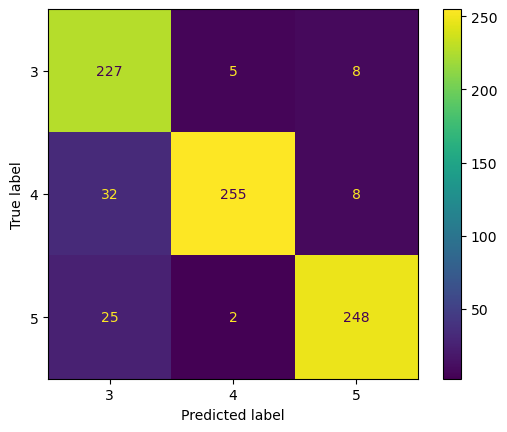

In [34]:
matrix_display.plot()

In [35]:
#Preguntar a la profesora por interpretación de esta matriz.

Por último, se hace un classification_report para poder observar la precisión, el recall y el f-score en las predicciones del algoritmo con base en los datos de validación

In [36]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           3       0.80      0.95      0.87       240
           4       0.97      0.86      0.92       295
           5       0.94      0.90      0.92       275

    accuracy                           0.90       810
   macro avg       0.90      0.90      0.90       810
weighted avg       0.91      0.90      0.90       810



Como se puede observar, la clase que menos presición tiene es el ODS 3, lo cual implica que esta es la clase cuyos datos el árbol con mayor frecuencia tiende a catalogar erroenameante. Sin embargo, el recall de esta clase es el más alto de todas, lo cual implica que lo que se categoriza dentro de la clase tiene una mayor precisión. Es decir, que aquello que el algoritmo, dentro del ODS 3, categoriza como ODS 3 y el resto lo hace con mayor precisión. Por otra parte, para hacer referencia al F-Score, el de las 3 clases es bastante alto, lo cual implica que #preguntar.

Evaluación Mejor Modelo de Naïves Bayes

              precision    recall  f1-score   support

           3       0.97      0.95      0.96       379
           4       0.98      0.97      0.98       429
           5       0.95      0.98      0.97       407

    accuracy                           0.97      1215
   macro avg       0.97      0.97      0.97      1215
weighted avg       0.97      0.97      0.97      1215

Exactitud: 0.968724279835391


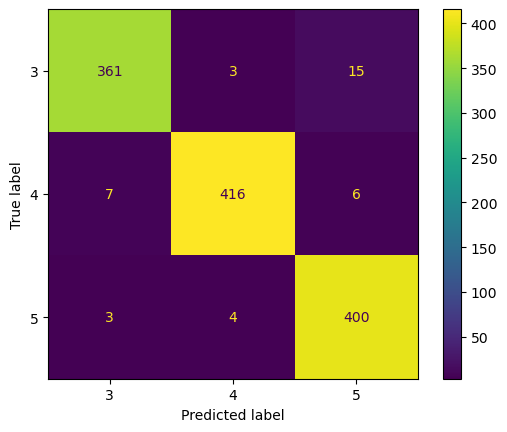

In [60]:
y_pred = best_NB.predict(x_validation)
matriz_confusionNB = confusion_matrix(y_validation, y_pred, labels=best_NB.classes_)
matrix_display_NB = ConfusionMatrixDisplay(confusion_matrix=matriz_confusionNB, display_labels=best_NB.classes_)
matrix_display_NB.plot()

report = classification_report(y_validation, y_pred)
grid_searchNB.best_params_, report
print(report)
print(f"Exactitud: {accuracy_score(y_validation, y_pred)}")
#print(f"Precisión: {precision_score(y_validation, y_pred)}")
#print(f"Recall: {recall_score(y_validation, y_pred)}")
#print(f"Puntuación F1: {f1_score(y_validation, y_pred)}")